# Time Series

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import dask.dataframe as dd
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_absolute_error, f1_score
import random
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
import pywt.data
from scipy.signal import find_peaks
from scipy.stats import linregress
from scipy import signal
import tensorflow as tf
from keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from scipy.fft import fft
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
directory = '/content/gdrive/MyDrive/EC503/project_forex_timeseries/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Load your CSV file
df = pd.read_csv(directory+"EURUSD_H1.csv")

# Drop unnecessary columns
df = df.drop(["Date", "Time", "Open"], axis=1)

# Normalize the "Volume" column
#scaler_volume = MinMaxScaler()
#df["Volume"] = scaler_volume.fit_transform(df["Volume"].values.reshape(-1, 1))

# Function to scale "High", "Low", and "Close" for each sequence
def scale_sequence(sequence):
    scaler = MinMaxScaler(feature_range=(0, 1))
    sequence[["Volume"]] = scaler.fit_transform(sequence[["Volume"]])
    maxVal = sequence["High"].max()
    minVal = sequence["Low"].min()
    sequence[["High", "Low", "Close"]] = (sequence[["High", "Low", "Close"]] - minVal) / (maxVal - minVal) * (0.9 - 0.1) + 0.1
    return maxVal, minVal, sequence

# Create lists for features and targets
features = []
targets  = []
closes    = []
window_size = 504
future_steps = 12
MaxMin = []
for i in range(len(df) - (window_size + future_steps)):
    sequence = df.iloc[i:i + window_size].copy()

    # Scale features
    maxVal, minVal, sequence[["High", "Low", "Close", "Volume"]] = scale_sequence(sequence)
    features.append(sequence[["High", "Low", "Close", "Volume"]])
    # Extract target values and scale them
    target_max_high = df.iloc[i+window_size:i+window_size + future_steps]["High"].max()
    target_min_low = df.iloc[i+window_size:i+window_size + future_steps]["Low"].min()
    close           = df.iloc[i+window_size-1]["Close"]
    '''
    close           = df.iloc[i+window_size-1]["Close"].mean()
    label = 0
    if target_min_low >= close:
      label = 1
    elif target_max_high <= close:
      label = -1
    elif abs((target_max_high-close)/(target_min_low-close))>2:
      label = 1
    elif abs((target_max_high-close)/(target_min_low-close))<1/2:
      label = -1
    targets.append(label)
    '''
    MaxMin.append([maxVal, minVal])
    temp_target = ([target_max_high, target_min_low]- minVal) / (maxVal - minVal) * (0.9 - 0.1) + 0.1
    target_max_high_scaled, target_min_low_scaled = 1/(1+np.exp(-5.4931*temp_target+2.7465))
    targets.append([target_max_high_scaled, target_min_low_scaled])
    closes.append(close.max())


# Convert lists to NumPy arrays
features_array = np.array(features)
targets_array = np.array(targets)
MaxMin_array  = np.array(MaxMin)
closes_array  = np.array(closes)
# Print the shapes of the arrays
print("Features shape:", features_array.shape)
print("Targets shape:", targets_array.shape)
print("MaxMin shape:", MaxMin_array.shape)
print("Closes shape:", closes_array.shape)


Features shape: (99484, 504, 4)
Targets shape: (99484, 2)
MaxMin shape: (99484, 2)
Closes shape: (99484,)


In [ ]:
np.save(directory+"features_array.npy", features_array)
np.save(directory+"targets_array.npy", targets_array)
np.save(directory+"MaxMin_array.npy", MaxMin_array)
np.save(directory+"closes_array.npy", closes_array)

In [ ]:
features_array = np.load(directory+"features_array.npy")
targets_array = np.load(directory+"targets_array.npy")
MaxMin_array = np.load(directory+"MaxMin_array.npy")
closes_array = np.load(directory+"closes_array.npy")

In [ ]:
test_size = 0.2  # Adjust as needed
random_state = 42  # Set a random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    features_array, targets_array, test_size=test_size, shuffle=False, random_state=random_state
)
np.random.seed(random_state)  # Set the seed for reproducibility
shuffle_indices = np.arange(X_train.shape[0])
np.random.shuffle(shuffle_indices)

X_train = X_train[shuffle_indices]
y_train = y_train[shuffle_indices]

MaxMin_train = MaxMin_array[:len(X_train),:]
MaxMin_train = MaxMin_train[shuffle_indices]
MaxMin_test  = MaxMin_array[len(X_train):,:]

# **Models**

In [ ]:
# Build the RNN model
input_shape = X_train.shape[1:]
l2_reg      = 0.1
input_layer = Input(shape=input_shape)

rnn_model = Sequential()
rnn_model.add(GRU(50, input_shape=input_shape, return_sequences=False, activation='relu', kernel_regularizer=l2(l2_reg)))
rnn_model.add(Flatten())


cnn_model = Sequential()
cnn_model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(input_shape[0], input_shape[1]),kernel_regularizer=l2(l2_reg)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_reg)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())

concatenated_output = Concatenate()([cnn_model(input_layer), rnn_model(input_layer)])

mix_layers  = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg))(concatenated_output)
mix_layers  = Dropout(0.5)(mix_layers)
mix_layers  = Dense(2, activation='sigmoid', kernel_regularizer=l2(l2_reg))(mix_layers)

mix_model = Model(inputs=input_layer, outputs=mix_layers)

# Now you can compile and train the combined model
optimizer = Adam(clipvalue=0.1, learning_rate=0.0001)
mix_model.compile(optimizer=optimizer , loss='mse')  # Use an appropriate optimizer and loss function
mix_model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))
#class_weights = {0:1, 1:2}
#combined_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
#combined_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), class_weight=class_weights)

Epoch 1/10
622/622 [==============================] - 155s 245ms/step - loss: 10.2703 - val_loss: 3.6939
Epoch 2/10
622/622 [==============================] - 150s 241ms/step - loss: 2.1112 - val_loss: 1.0225
Epoch 3/10
622/622 [==============================] - 151s 243ms/step - loss: nan - val_loss: nan
Epoch 4/10
622/622 [==============================] - 152s 244ms/step - loss: nan - val_loss: nan
Epoch 5/10
247/622 [==========>...................] - ETA: 1:23 - loss: nan

KeyboardInterrupt: ignored

In [ ]:
# Build the RNN model

rnn_model = Sequential()
rnn_model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))

rnn_input = Input(shape=(X_train.shape[1], X_train.shape[2]))

output_layer = rnn_model.layers[-1]  # Assuming the last layer is the output layer
output_shape_of_rnn = output_layer.output_shape[1]  # Assuming the first dimension is batch size, so [0] is skipped

cnn_model = Sequential()
cnn_model.add(Conv1D(64, kernel_size=3, input_shape=(output_shape_of_rnn, 1), activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))  # Adding a MaxPooling layer
cnn_model.add(Conv1D(128, kernel_size=3, activation='relu'))  # Adding another convolutional layer
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))  # Add more layers to the CNN as needed
cnn_model.add(Dense(2, activation='sigmoid'))  # Add more layers to the CNN as needed

cnn_output = cnn_model(rnn_model(rnn_input))

combined_model = Model(inputs=rnn_input, outputs=cnn_output)

# Now you can compile and train the combined model
combined_model.compile(optimizer='adam', loss='mse')  # Use an appropriate optimizer and loss function
combined_model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test))
#class_weights = {0:1, 1:2}
#combined_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
#combined_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), class_weight=class_weights)

Epoch 1/10
311/311 [==============================] - 26s 44ms/step - loss: 0.0068 - val_loss: 0.0035
Epoch 2/10
311/311 [==============================] - 10s 33ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 3/10
311/311 [==============================] - 10s 33ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 4/10
311/311 [==============================] - 10s 33ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 5/10
311/311 [==============================] - 10s 33ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 6/10
311/311 [==============================] - 10s 33ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 7/10
311/311 [==============================] - 10s 33ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 8/10
311/311 [==============================] - 10s 33ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 9/10
311/311 [==============================] - 10s 33ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 10/10
311/311 [==============================] - 10s 33ms/step - loss: 0.003

In [ ]:
def create_cnn_model(input_shape):
    l2_reg      = 0.0
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, input_shape=input_shape, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(MaxPooling1D(pool_size=2))  # Adding a MaxPooling layer
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(MaxPooling1D(pool_size=2))
    #LSTM layers for capturing temporal dependencies
    model.add(LSTM(50, activation='relu', return_sequences=True))
    model.add(LSTM(50, activation='relu'))

    # Flatten layer to connect the LSTM output to Dense layers
    model.add(Flatten())

    # Dense layers for regression output
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mse')
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    return model

input_shape = X_train.shape[1:]
model = create_cnn_model(input_shape)
model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))
'''
# Create and compile the CNN model
class_weights = {0:1, 1:2}

model_short = create_cnn_model(input_shape)
model_short.fit(X_train, y_train_short, epochs=20, validation_data=(X_test, y_test_short), class_weight=class_weights)
test_loss, test_acc = model_short.evaluate(X_test, y_test_short, verbose=2)
print(f"\nTest accuracy short: {test_acc * 100:.2f}%")

model_long = create_cnn_model(input_shape)
model_long.fit(X_train, y_train_long, epochs=20, validation_data=(X_test, y_test_long), class_weight=class_weights)
test_loss, test_acc = model_long.evaluate(X_test, y_test_long, verbose=2)
print(f"\nTest accuracy long: {test_acc * 100:.2f}%")
'''

Epoch 1/20
1244/1244 [==============================] - 224s 173ms/step - loss: 0.0073 - val_loss: 0.0043
Epoch 2/20
1244/1244 [==============================] - 209s 168ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 3/20
1244/1244 [==============================] - 210s 169ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 4/20
 908/1244 [====================>.........] - ETA: 54s - loss: 0.0038

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import mean_squared_error
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
print(mean_squared_error(y_train,y_pred_train))
print(mean_squared_error(y_test,y_pred_test))

622/622 [==============================] - 1s 2ms/step
0.009651477334639641
0.010067351588847348


# **Plotting**

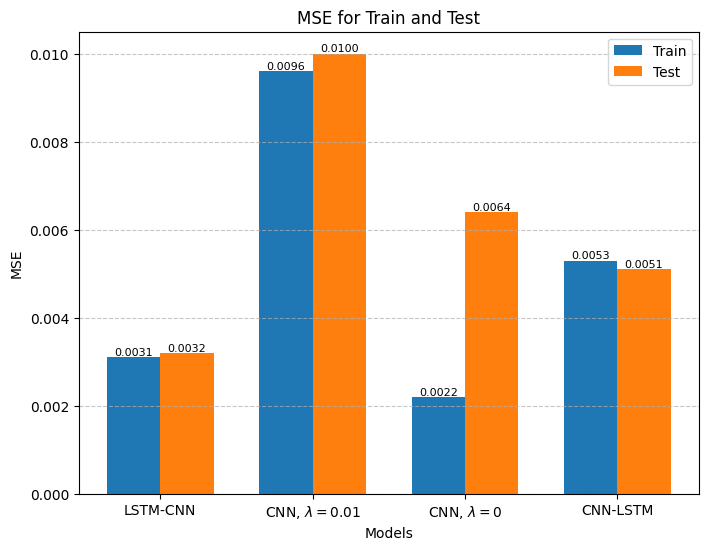

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# MSE values for train and test
lstm_cnn_mse = [0.0031, 0.0032]
cnn_reg_mse = [0.0096, 0.0100]
cnn_mse = [0.0022, 0.0064]
raw_cnn_lstm_mse = [0.0053, 0.0051]

fig, ax = plt.subplots(figsize=(8, 6))

# Model names for x-axis
models = ['LSTM-CNN', 'CNN, $\lambda=0.01$', 'CNN, $\lambda=0$', 'CNN-LSTM']

# Bar width
bar_width = 0.35

# Set up bar positions
train_positions = np.arange(len(models))
test_positions = [pos + bar_width for pos in train_positions]

# Create bar plots for both train and test MSE
line1 = plt.bar(train_positions[0], lstm_cnn_mse[0], width=bar_width, label='Train')
line2 = plt.bar(test_positions[0], lstm_cnn_mse[1], width=bar_width, label='Test')

for bar in line1:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{bar.get_height():.4f}', ha='center', va='bottom', fontsize=8)

for bar in line2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{bar.get_height():.4f}', ha='center', va='bottom', fontsize=8)

a = line1[0].get_facecolor()[0:3]
b = line2[0].get_facecolor()[0:3]

line1 = plt.bar(train_positions[1], cnn_reg_mse[0], width=bar_width, color=a)
line2 = plt.bar(test_positions[1], cnn_reg_mse[1], width=bar_width, color=b)

for bar in line1:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{bar.get_height():.4f}', ha='center', va='bottom', fontsize=8)

for bar in line2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{bar.get_height():.4f}', ha='center', va='bottom', fontsize=8)

line1 = plt.bar(train_positions[2], cnn_mse[0], width=bar_width, color=a)
line2 = plt.bar(test_positions[2], cnn_mse[1], width=bar_width, color=b)

for bar in line1:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{bar.get_height():.4f}', ha='center', va='bottom', fontsize=8)

for bar in line2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{bar.get_height():.4f}', ha='center', va='bottom', fontsize=8)

line1 = plt.bar(train_positions[3], raw_cnn_lstm_mse[0], width=bar_width, color=a)
line2 = plt.bar(test_positions[3], raw_cnn_lstm_mse[1], width=bar_width, color=b)

for bar in line1:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{bar.get_height():.4f}', ha='center', va='bottom', fontsize=8)

for bar in line2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{bar.get_height():.4f}', ha='center', va='bottom', fontsize=8)


# Set labels and title
plt.xlabel('Models')
plt.ylabel('MSE')
plt.title('MSE for Train and Test')
plt.xticks([pos + bar_width / 2 for pos in train_positions], models, rotation=0)
#plt.yticks([x/1000 for x in range(11)])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend
plt.legend()


plt.savefig(directory+'bars.png', dpi=500)
# Show the plot
plt.show()


